# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3423514390762609103
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10465773028794736940
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Sat Dec 18 08:11:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    31W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'VGG16'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 3
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2"
T_all_labels = "T0", "T1", "T2"

#base_path = ''
base_path = 'gdrive/My Drive/Research_3_1_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_VGG16_None S_VGG16_imagenet T_VGG16_None T_VGG16_imagenet


['S_VGG16_imagenet', 'S_VGG16_None', 'T_VGG16_imagenet', 'T_VGG16_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1920, 128, 128, 3) (1920, 1)
(640, 128, 128, 3) (640, 1)
(640, 128, 128, 3) (640, 1)

(1440, 128, 128, 3) (1440, 1)
(480, 128, 128, 3) (480, 1)
(480, 128, 128, 3) (480, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1920, 128, 128, 3) (1920, 3)
(640, 128, 128, 3) (640, 3)
(640, 128, 128, 3) (640, 3)

(1440, 128, 128, 3) (1440, 3)
(480, 128, 128, 3) (480, 3)
(480, 128, 128, 3) (480, 3)


## 2-2. Image Check

xTrain_S image Numbers :  1920
xTrain_S image Numbers // 10 :  192
10


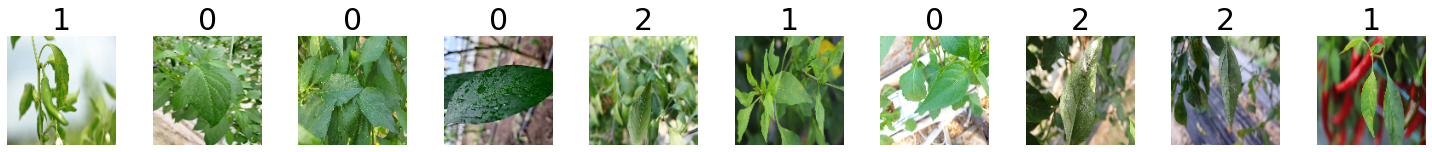

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  1440
xTrain_S image Numbers // 10 :  144
10


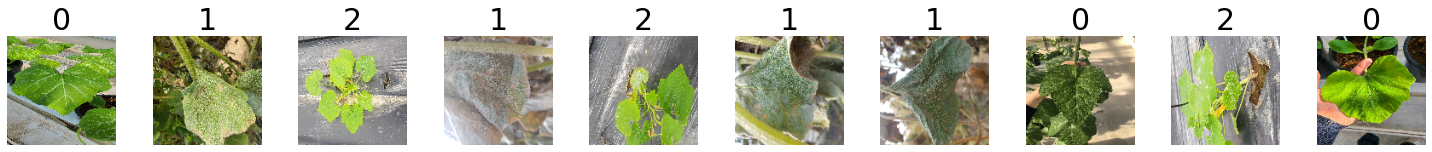

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.VGG16 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.VGG16 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 16s 160ms/step - loss: 1.0984 - accuracy: 0.4922 - val_loss: 1.0595 - val_accuracy: 0.5000
Epoch 2/100
30/30 [==============================] - 4s 148ms/step - loss: 1.0460 - accuracy: 0.5000 - val_loss: 1.0397 - val_accuracy: 0.5000
Epoch 3/100
30/30 [==============================] - 4s 144ms/step - loss: 1.0417 - accuracy: 0.5000 - val_loss: 1.0417 - val_accuracy: 0.5000
Epoch 4/100
30/30 [==============================] - 4s 144ms/step - loss: 1.0410 - accuracy: 0.5000 - val_loss: 1.0430 - val_accuracy: 0.5000
Epoch 5/100
30/30 [==============================] - 4s 144ms/step - loss: 1.0433 - accuracy: 0.5000 - val_loss: 1.0418 - val_accuracy: 0.5000
Epoch 6/100
30/30 [==============================] - 4s 144ms/step - loss: 1.0423 - accuracy: 0.5000 - val_loss: 1.0402 - val_accuracy: 0.5000
Epoch 7/100
30/30 [==============================] - 4s 144ms/step - loss: 1.0406 - accuracy: 0.5000 - val_loss: 1.0398 - val_accuracy: 0.500

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.098389,0.492188,1.059520,0.5
1,1.045977,0.500000,1.039722,0.5
2,1.041738,0.500000,1.041736,0.5
3,1.040995,0.500000,1.043009,0.5
4,1.043342,0.500000,1.041825,0.5
5,1.042312,0.500000,1.040195,0.5
6,1.040564,0.500000,1.039848,0.5
7,1.042826,0.500000,1.040130,0.5
8,1.040874,0.500000,1.040412,0.5
9,1.042383,0.500000,1.043437,0.5


Minimum validation loss: 1.0397217273712158
Maximum validation accuracy: 0.5


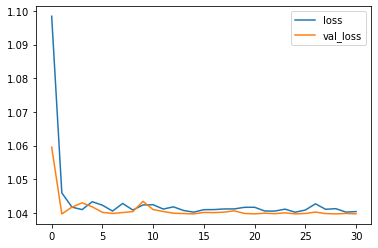

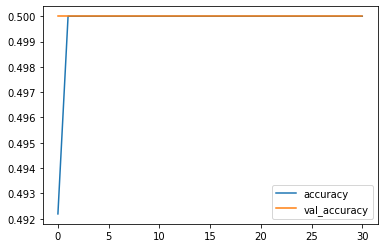

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
20/20 [==============================] - 2s 23ms/step - loss: 1.0595 - accuracy: 0.5000
test loss, test acc: [1.059519648551941, 0.5]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

20/20 [==============================] - 1s 20ms/step


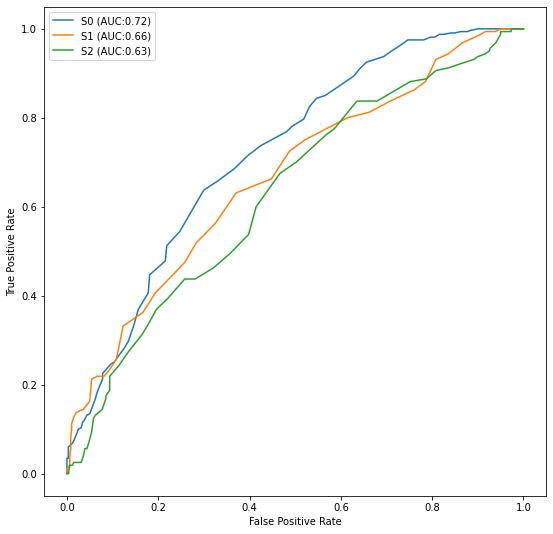

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

58900480/58889256 [==============================] - 0s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 5s 156ms/step - loss: 11.2604 - accuracy: 0.4677 - val_loss: 1.0378 - val_accuracy: 0.5000
Epoch 2/100
30/30 [==============================] - 4s 144ms/step - loss: 1.0373 - accuracy: 0.5000 - val_loss: 1.0171 - val_accuracy: 0.5000
Epoch 3/100
30/30 [==============================] - 4s 146ms/step - loss: 1.0055 - accuracy: 0.5068 - val_loss: 0.9371 - val_accuracy: 0.5891
Epoch 4/100
30/30 [==============================] - 4s 145ms/step - loss: 0.9759 - accuracy: 0.5276 - val_loss: 0.9109 - val_accuracy: 0.5766
Epoch 5/100
30/30 [==============================] - 4s 144ms/step - loss: 0.9462 - accuracy: 0.5516 - val_loss: 0.9341 - val_accuracy: 0.5750
Epoch 6/100
30/30 [==============================] - 4s 146ms/step - loss: 0.9121 - accuracy: 0.5771 - val_loss: 0.8443 - val_accuracy: 0.6078
Epoch 7/100
30/30 [==============================] - 4s 146ms/step - loss: 0.8779 - accuracy: 0.5932 - val_loss: 0.8102 - val_accuracy: 0.629

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,11.260423,0.467708,1.037823,0.500000
1,1.037314,0.500000,1.017057,0.500000
2,1.005545,0.506771,0.937074,0.589063
3,0.975880,0.527604,0.910910,0.576563
4,0.946198,0.551562,0.934079,0.575000
...,...,...,...,...
78,0.000042,1.000000,1.224262,0.881250
79,0.000039,1.000000,1.252496,0.879687
80,0.000036,1.000000,1.279506,0.881250
81,0.000031,1.000000,1.299422,0.879687


Minimum validation loss: 0.366138219833374
Maximum validation accuracy: 0.8968750238418579


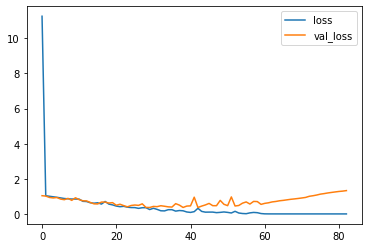

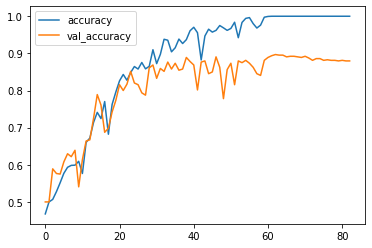

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
20/20 [==============================] - 1s 23ms/step - loss: 0.5784 - accuracy: 0.8922
test loss, test acc: [0.5784012079238892, 0.8921874761581421]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

20/20 [==============================] - 1s 21ms/step


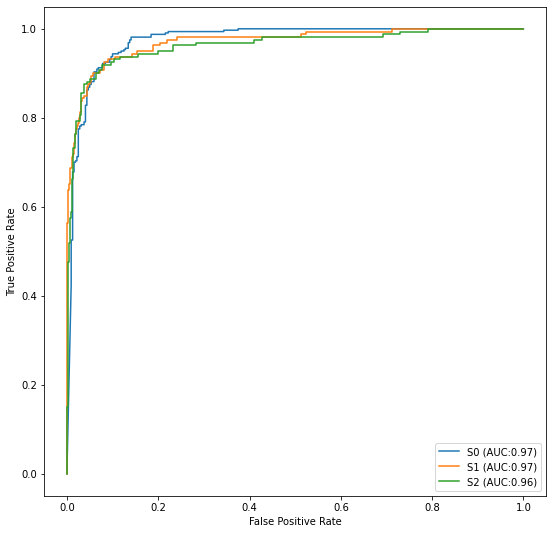

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 5s 192ms/step - loss: 1.0801 - accuracy: 0.5000 - val_loss: 1.0630 - val_accuracy: 0.5000
Epoch 2/100
23/23 [==============================] - 3s 143ms/step - loss: 1.0480 - accuracy: 0.5000 - val_loss: 1.0421 - val_accuracy: 0.5000
Epoch 3/100
23/23 [==============================] - 3s 142ms/step - loss: 1.0427 - accuracy: 0.5000 - val_loss: 1.0405 - val_accuracy: 0.5000
Epoch 4/100
23/23 [==============================] - 3s 142ms/step - loss: 1.0308 - accuracy: 0.5028 - val_loss: 1.6108 - val_accuracy: 0.5000
Epoch 5/100
23/23 [==============================] - 3s 142ms/step - loss: 1.1066 - accuracy: 0.5000 - val_loss: 1.0535 - val_accuracy: 0.5000
Epoch 6/100
23/23 [==============================] - 3s 142ms/step - loss: 1.0458 - accuracy: 0.5000 - val_loss: 1.0485 - val_accuracy: 0.5000
Epoch 7/100
23/23 [==============================] - 3s 142ms/step - loss: 1.0454 - accuracy: 0.5000 - val_loss: 1.0399 - val_accuracy: 0.5000

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,1.080055,0.500000,1.062955,0.5
1,1.048048,0.500000,1.042083,0.5
2,1.042739,0.500000,1.040532,0.5
3,1.030820,0.502778,1.610779,0.5
4,1.106641,0.500000,1.053548,0.5
5,1.045819,0.500000,1.048542,0.5
6,1.045382,0.500000,1.039850,0.5
7,1.040925,0.500000,1.039843,0.5
8,1.041875,0.500000,1.039978,0.5
9,1.040965,0.500000,1.040072,0.5


Minimum validation loss: 1.0381519794464111
Maximum validation accuracy: 0.5


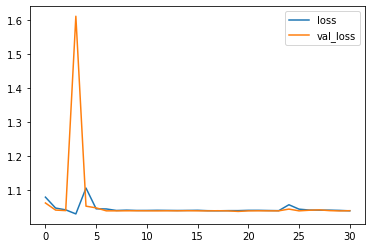

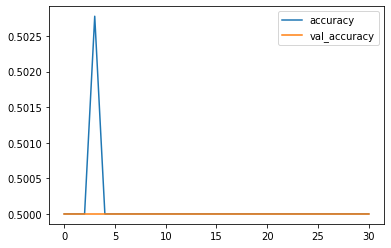

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
15/15 [==============================] - 1s 23ms/step - loss: 1.0630 - accuracy: 0.5000
test loss, test acc: [1.0629551410675049, 0.5]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

15/15 [==============================] - 0s 20ms/step


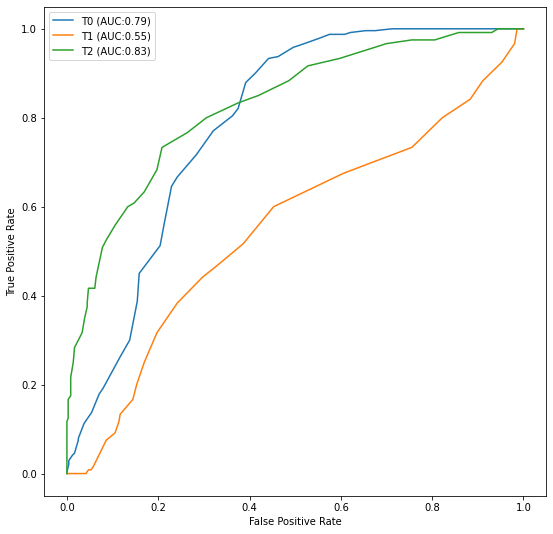

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 4s 157ms/step - loss: 1.2795 - accuracy: 0.4639 - val_loss: 1.0502 - val_accuracy: 0.5000
Epoch 2/100
23/23 [==============================] - 3s 143ms/step - loss: 1.0448 - accuracy: 0.5000 - val_loss: 1.0363 - val_accuracy: 0.5000
Epoch 3/100
23/23 [==============================] - 3s 142ms/step - loss: 1.0434 - accuracy: 0.5007 - val_loss: 1.0251 - val_accuracy: 0.5000
Epoch 4/100
23/23 [==============================] - 3s 144ms/step - loss: 0.9665 - accuracy: 0.5201 - val_loss: 0.8745 - val_accuracy: 0.5958
Epoch 5/100
23/23 [==============================] - 3s 145ms/step - loss: 0.8033 - accuracy: 0.6319 - val_loss: 0.6969 - val_accuracy: 0.6812
Epoch 6/100
23/23 [==============================] - 3s 145ms/step - loss: 0.6113 - accuracy: 0.7382 - val_loss: 0.6325 - val_accuracy: 0.7667
Epoch 7/100
23/23 [==============================] - 3s 144ms/step - loss: 0.3966 - accuracy: 0.8583 - val_loss: 0.4571 - val_accuracy: 0.8271

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,1.279491,0.463889,1.050178,0.500000
1,1.044847,0.500000,1.036308,0.500000
2,1.043422,0.500694,1.025094,0.500000
3,0.966459,0.520139,0.874544,0.595833
4,0.803324,0.631944,0.696903,0.681250
...,...,...,...,...
75,0.005185,0.998611,0.160313,0.975000
76,0.005371,0.997917,0.185408,0.964583
77,0.070160,0.979861,1.124621,0.727083
78,0.142132,0.959028,0.113029,0.956250


Minimum validation loss: 0.10138174146413803
Maximum validation accuracy: 0.9750000238418579


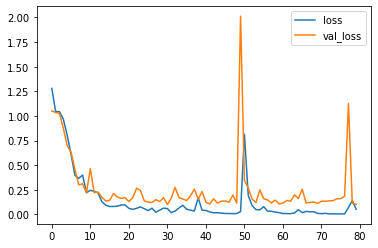

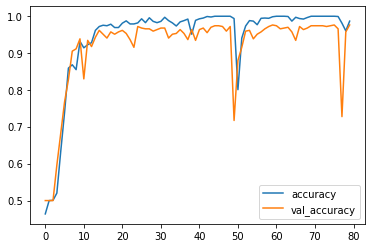

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
15/15 [==============================] - 1s 23ms/step - loss: 0.0545 - accuracy: 0.9812
test loss, test acc: [0.05450378730893135, 0.981249988079071]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

15/15 [==============================] - 0s 21ms/step


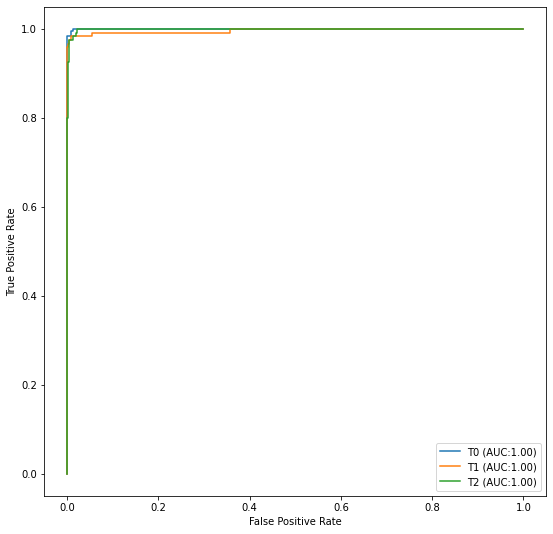

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_VGG16_None
test loss, test acc: [1.059519648551941, 0.5]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_VGG16_imagenet
test loss, test acc: [0.5784012079238892, 0.8921874761581421]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_VGG16_None
test loss, test acc: [1.0629551410675049, 0.5]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_VGG16_imagenet
test loss, test acc: [0.05450378730893135, 0.981249988079071]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_VGG16_None →→→ Target Test
15/15 [==============================] - 0s 22ms/step - loss: 1.0595 - accuracy: 0.5000
test loss, test acc: [1.0595201253890991, 0.5]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_VGG16_imagenet →→→ Target Test
15/15 [==============================] - 0s 22ms/step - loss: 8.6071 - accuracy: 0.5104
test loss, test acc: [8.607061386108398, 0.5104166865348816]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_VGG16_None →→→ Source Test
20/20 [==============================] - 0s 23ms/step - loss: 1.0630 - accuracy: 0.5000
test loss, test acc: [1.062955617904663, 0.5]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_VGG16_imagenet →→→ Source Test
20/20 [==============================] - 0s 23ms/step - loss: 3.1556 - accuracy: 0.3875
test loss, test acc: [3.1555581092834473, 0.38749998807907104]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )